In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.metrics import pairwise_distances
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import umap
from sklearn.manifold import Isomap
from sklearn.manifold import MDS
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import TSNE

DOWNSAMPLING_COLORS = {
    'Decimate': '#56B4E9', # Light blue
    'M4': '#D55E00', # Vermilion
    'MinMax': '#009E73', # Bluish green 
    'LTTB': '#CC79A7', # Reddish purple
    'MinMaxLTTB': '#E69F00', # Orange
    'Original': 'Black'
}

data_dir = '../results'
classification_dir = '../results/classification'

factors=[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 200, 300, 400, 500, 1000]
downsamplers=["Decimate","LTTB","MinMax","M4","MinMaxLTTB"]

def format_feature_names(original, add_params=True):
    feat_names = []
    for feat_name in original:
        first = feat_name.replace('value__', '')
        second = first.split('__')
        feature = second[0]
        params = second[1:]

        if params and add_params:
            string = '('
            for param in params:
                var, value = param.rsplit('_', 1)
                string += f'{var}={value}, '
            string = string[:-2] + ')'
            feature += string
        feat_names.append(feature)
    return feat_names

/opt/homebrew/Caskroom/miniconda/base/envs/emglab/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_feat_importance_df(factors, downsamplers, classification_dir):
    feat_importances = pd.read_csv(f'{classification_dir}/feature_importances_raw.csv')

    df_all = feat_importances.pivot_table(
        index=["downsampler", "factor", "fold"],
        columns="feature_name",
        values="importance_impurity", #importance_impurity or importance_permutation
        fill_value=0
    ).reset_index()

    df_all["factor"] = df_all["factor"].astype(int)
    df_all["fold"] = df_all["fold"].astype(int)
    df_all = df_all[df_all["factor"].isin(factors + [1])]
    df_all["downsampler"] = df_all["downsampler"].astype(str)
    df_all = df_all[df_all["downsampler"].isin(downsamplers + ["Original"])]
    df_all = df_all.fillna(0)
    return df_all

df_feat_importance = load_feat_importance_df(factors, downsamplers, classification_dir)
df_feat_importance.head()

feature_name,downsampler,factor,fold,abs_energy,absolute_maximum,absolute_sum_of_changes,"agg_autocorrelation(f_agg=""mean"", maxlag=40)","agg_autocorrelation(f_agg=""median"", maxlag=40)","agg_autocorrelation(f_agg=""var"", maxlag=40)","agg_linear_trend(attr=""intercept"", chunk_len=10, f_agg=""max"")",...,standard_deviation,sum_of_reoccurring_data_points,sum_of_reoccurring_values,sum_values,time_reversal_asymmetry_statistic(lag=1),time_reversal_asymmetry_statistic(lag=2),time_reversal_asymmetry_statistic(lag=3),value_count(value=0),variance,variation_coefficient
0,Decimate,2,1,0.004960,0.011167,0.001682,0.001914,0.002364,0.003240,0.0,...,0.005895,0.0,0.0,0.002276,0.002023,0.002080,0.001810,0.0,0.005644,0.003080
1,Decimate,2,2,0.006224,0.013029,0.001821,0.002199,0.002367,0.003183,0.0,...,0.006825,0.0,0.0,0.002339,0.001873,0.001866,0.001855,0.0,0.006510,0.002903
2,Decimate,2,3,0.004531,0.013669,0.001732,0.002136,0.002031,0.002867,0.0,...,0.005693,0.0,0.0,0.002253,0.001946,0.002054,0.001819,0.0,0.005587,0.002749
3,Decimate,2,4,0.005860,0.011087,0.001691,0.002006,0.002518,0.003500,0.0,...,0.005730,0.0,0.0,0.002205,0.001752,0.001850,0.001957,0.0,0.006132,0.002590
4,Decimate,2,5,0.005712,0.012827,0.001739,0.001926,0.002248,0.002945,0.0,...,0.005827,0.0,0.0,0.002101,0.001883,0.001974,0.002020,0.0,0.004867,0.003260


In [3]:
def evaluate_embedding(X, X_emb, n_neighbors=15):
    D_high = pairwise_distances(X)
    D_low = pairwise_distances(X_emb)
    
    neigh_high = np.argsort(D_high, axis=1)[:, 1:n_neighbors+1]
    neigh_low  = np.argsort(D_low, axis=1)[:, 1:n_neighbors+1]
    
    dist_corr = np.corrcoef(D_high.ravel(), D_low.ravel())[0, 1]
    
    spear_corr, _ = spearmanr(D_high.ravel(), D_low.ravel())
    
    return {
        "distance_corr": round(dist_corr, 4),
        "spearman_corr": round(spear_corr, 4)
    }

def pca_embedding(X, n_components):
    pca = PCA(n_components=n_components)
    embedding = pca.fit_transform(X)
    return embedding, evaluate_embedding(X, embedding)

def kernel_pca_embedding(X, n_components, kernel):
    kpca = KernelPCA(n_components=n_components, kernel=kernel, random_state=0)
    embedding = kpca.fit_transform(X)
    return embedding, evaluate_embedding(X, embedding)

def umap_embedding(X, n_components, n_neighbors, min_dist, random_state):
    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state
    )
    embedding = reducer.fit_transform(X)
    return embedding, evaluate_embedding(X, embedding)

def isomap_embedding(X, n_components, n_neighbors):
    isomap = Isomap(
        n_components=n_components,
        n_neighbors=n_neighbors,
    )
    embedding = isomap.fit_transform(X)
    return embedding, evaluate_embedding(X, embedding)

def mds_embedding(X, n_components, max_iter, n_init, normalised_stress=False):
    mds_scaling = MDS(
        n_components=n_components,
        max_iter=max_iter,
        n_init=n_init,
        random_state=0,
        normalized_stress=normalised_stress,
    )
    embedding = mds_scaling.fit_transform(X)
    return embedding, evaluate_embedding(X, embedding)

def spectral_embedding(X, n_components, n_neighbors):
    spectral = SpectralEmbedding(
        n_components=n_components,
        n_neighbors=n_neighbors,
        random_state=0
    )
    embedding = spectral.fit_transform(X)
    return embedding, evaluate_embedding(X, embedding)


def tsne_embedding(X, n_components, perplexity, learning_rate, max_iter, random_state):
    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        learning_rate=learning_rate,
        max_iter=max_iter,
        random_state=random_state
    )
    embedding = tsne.fit_transform(X)
    return embedding, evaluate_embedding(X, embedding)


X = df_feat_importance.drop(columns=["downsampler", "factor", "fold"]).values

X_pca, eval_pca = pca_embedding(X=X, n_components=3)
X_kpca, eval_kpca = kernel_pca_embedding(X=X, n_components=3, kernel='rbf')
X_umap, eval_umap = umap_embedding(X=X, n_components=3, n_neighbors=15, min_dist=0.01, random_state=0)
X_isomap, eval_isomap = isomap_embedding(X=X, n_components=3, n_neighbors=15)
X_mds, eval_mds = mds_embedding(X=X, n_components=3, max_iter=300, n_init=4, normalised_stress=False)
X_spectral, eval_spectral = spectral_embedding(X=X, n_components=3, n_neighbors=15)
X_tsne, eval_tsne = tsne_embedding(X=X, n_components=3, perplexity=30, learning_rate=200, max_iter=1000, random_state=0)

print("PCA Evaluation:", eval_pca)
print("Kernel PCA Evaluation:", eval_kpca)
print("UMAP Evaluation:", eval_umap)
print("Isomap Evaluation:", eval_isomap)
print("MDS Evaluation:", eval_mds)
print("Spectral Embedding Evaluation:", eval_spectral)
print("t-SNE Evaluation:", eval_tsne)

/opt/homebrew/Caskroom/miniconda/base/envs/emglab/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniconda/base/envs/emglab/lib/python3.13/site-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 11 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/opt/homebrew/Caskroom/miniconda/base/envs/emglab/lib/python3.13/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/opt/homebrew/Caskroom/miniconda/base/envs/emglab/lib/python3.13/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok

PCA Evaluation: {'distance_corr': np.float64(0.8496), 'spearman_corr': np.float64(0.8559)}
Kernel PCA Evaluation: {'distance_corr': np.float64(0.8496), 'spearman_corr': np.float64(0.8559)}
UMAP Evaluation: {'distance_corr': np.float64(0.4341), 'spearman_corr': np.float64(0.3885)}
Isomap Evaluation: {'distance_corr': np.float64(0.7781), 'spearman_corr': np.float64(0.7824)}
MDS Evaluation: {'distance_corr': np.float64(0.9272), 'spearman_corr': np.float64(0.9278)}
Spectral Embedding Evaluation: {'distance_corr': np.float64(-0.0577), 'spearman_corr': np.float64(0.002)}
t-SNE Evaluation: {'distance_corr': np.float64(0.5914), 'spearman_corr': np.float64(0.5402)}


Text(0.5, 1.0, 'Embedding Methods Performance Comparison')

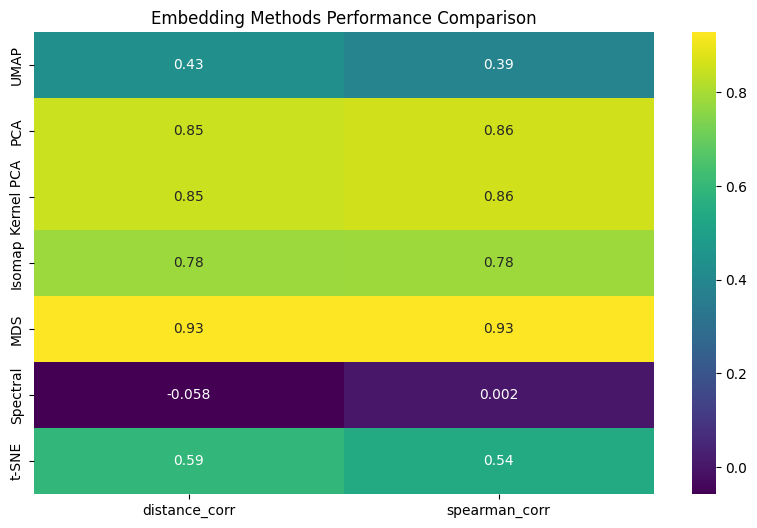

In [4]:
embeddings_perf = {
    'UMAP': eval_umap,
    'PCA': eval_pca,
    'Kernel PCA': eval_kpca,
    'Isomap': eval_isomap,
    'MDS': eval_mds,
    'Spectral': eval_spectral,
    't-SNE': eval_tsne,
}

df_embeddings_perf = pd.DataFrame(embeddings_perf).T
plt.figure(figsize=(10, 6))
sns.heatmap(df_embeddings_perf, annot=True, cmap='viridis')
plt.title('Embedding Methods Performance Comparison')

In [5]:
def prepare_embedding_for_plotting(embedding, source_df, key, n_components=3):
    embedding_df = pd.DataFrame(embedding, columns=[f"D_{i+1}" for i in range(n_components)])
    embedding_df["downsampler"] = source_df["downsampler"].values
    embedding_df["factor"] = source_df["factor"].values
    embedding_df[key] = source_df[key].values
    return embedding_df


def plot_embedding(embedding, source_df, key, n_components, title="3D Embedding"):
    embedding_df = prepare_embedding_for_plotting(embedding, source_df, key, n_components=n_components)
    fig = go.Figure()

    for ds, sub in embedding_df.groupby('downsampler'):
        
        fig.add_trace(
            go.Scatter3d(
                x=[None], y=[None], z=[None], 
                mode='markers',
                marker=dict(size=8, color=DOWNSAMPLING_COLORS[ds]),
                name=ds,
                showlegend=True,
                hoverinfo='none'
            )
        )
        
        for key_v, sub_f in sub.groupby(key):
            sub_f_original = sub_f[sub_f['factor'] == 1]
            sub_f_downsampled = sub_f[sub_f['factor'] > 1]
            
            if not sub_f_original.empty:
                x_orig, y_orig, z_orig = sub_f_original['D_1'], sub_f_original['D_2'], sub_f_original['D_3']
                fig.add_trace(
                    go.Scatter3d(
                        x=x_orig, y=y_orig, z=z_orig,
                        mode='markers',
                        marker=dict(size=6, color=DOWNSAMPLING_COLORS[ds], symbol='circle', line=dict(width=1, color='Black')),
                        name=f"{ds} (Original {key}={key_v})",
                        showlegend=False, 
                        hovertext=[f'{ds} | factor={f} | {key}={key_v}' for f in sub_f_original['factor']],
                        hoverinfo='text'
                    )
                )

            if not sub_f_downsampled.empty:
                x_ds, y_ds, z_ds = sub_f_downsampled['D_1'], sub_f_downsampled['D_2'], sub_f_downsampled['D_3']
                
                fig.add_trace(
                    go.Scatter3d(
                        x=x_ds, y=y_ds, z=z_ds,
                        mode='lines+markers',
                        line=dict(color=DOWNSAMPLING_COLORS[ds], width=2),
                        marker=dict(size=4, color=DOWNSAMPLING_COLORS[ds], symbol='circle'),
                        name=f"{ds} (Trajectory {key}={key_v})",
                        showlegend=False,
                        hovertext=[f'{ds} | factor={f} | {key}={key_v}' for f in sub_f_downsampled['factor']],
                        hoverinfo='text'
                    )
                )

    fig.update_layout(
        title={
            'text': title,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        width=1000, height=800,
        scene=dict(xaxis_title='D1', yaxis_title='D2', zaxis_title='D3'),
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=10,
            pad=0
        ),
        legend=dict(
            orientation="h",
            yanchor="top",
            y=0.0,
            xanchor="center",
            x=0.5,
            traceorder="normal",
            font=dict(size=12),
            tracegroupgap=5,
            itemwidth=30,
        )
    )
    fig.show()

plot_embedding(X_mds, df_feat_importance, "fold", n_components=3, title="Multidimensional scaling of feature importances after downsampling")